<div align='center'>

# Artificial Neural Networks - Part 1

### Part of Scientific-ML-Notes 

[![GitHub](https://img.shields.io/badge/GitHub-Repository-black?logo=github&scale=5)](https://github.com/mhnaderi/Scientific-ML-Notes)

---

In [ ]:
# Always run this cell first to import all necessary libraries and set up the notebook environment

! pip install -q optax, equinox

import jax
import jax.numpy as jnp 
import jax.numpy.linalg as la
from jax import jit, grad, vmap, value_and_grad, random

import optax
import equinox as eqx
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt  
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams.update({
    "font.family": "serif",              
    "figure.facecolor": 'white',        
    "axes.facecolor": 'white' 
})

# Limitations of Fixed Basis Functions

Linear basis function models involve creating linear combinations of basis functions $\mathbf{\Phi}(\mathbf{x})$ and are expressed as:

$$ f(\mathbf{x}; \boldsymbol{\theta}) = \mathbf{\Phi}(\mathbf{x}) \boldsymbol{\theta} $$

These models allow us to choose arbitrary nonlinear basis functions, and theoretically, with a sufficiently rich set of basis functions, we can approximate any desired function to an arbitrary degree of accuracy. This suggests that linear basis function models could serve as a universal framework for solving regression and classification tasks in machine learning. **However, significant limitations arise from the fact that the basis functions $\mathbf{\Phi}(\mathbf{x})$ are fixed and do not adapt based on the training data.**

## The Curse of Dimensionality

Let's start with a simple regression model involving a single input variable, represented as a polynomial of degree $M$. When we extend this model to incorporate $D$ input variables $\{ x_1, x_2, \ldots, x_D \}$, we find that the number of coefficients (parameters) grows rapidly with the number of inputs. Specifically, for a polynomial of degree $M$ in $D$ variables, the number of coefficients increases on the order of $\mathcal{O}(D^M)$. This exponential growth means that in high-dimensional spaces, polynomial models can quickly become computationally infeasible and practically useless. This phenomenon is known as the **curse of dimensionality**.

## Properties of High-Dimensional Spaces

Our geometrical intuitions, shaped by living in a three-dimensional world, often mislead us when we consider high-dimensional spaces. For instance, let's examine a hypersphere with a radius $r = 1$ in $D$ dimensions. If we calculate the fraction of the hypersphere's volume that lies between the radii $r = 1 - \epsilon$ and $r = 1$, we find that as $D$ becomes large, this fraction approaches 1 even for very small $\epsilon$. In other words, in high-dimensional spaces, nearly all the volume of the hypersphere is concentrated in a thin shell near its outer surface!

Despite the challenges posed by high-dimensional spaces, there are also benefits. For instance, consider a dataset where each point is described by a pair of features $\{ x_1, x_2 \}$, and suppose the classes are linearly separable when both features are considered together. However, if we only have access to $x_1$, the classes may significantly overlap, making classification much more difficult. Thus, working in the higher-dimensional space makes the problem easier, as it allows us to capture more information that helps to distinguish between classes.

## Data Manifolds

Imagine attempting to learn a completely random mapping from every possible $28 \times 28$ binary image to one of ten categories. Since this mapping lacks any inherent structure, the only viable strategy would be to memorize all $2^{784}$ possible assignments—a clearly impractical approach. However, in real-world scenarios, data typically resides within a region of the space that has a much lower effective dimensionality.

For example, consider images of handwritten digits. Each image corresponds to a point in a high-dimensional space where the dimensionality equals the number of pixels (e.g., 784 for a $28 \times 28$ image). Despite this high dimensionality, the variations in the images—for instance, differences in the vertical and horizontal positions of the digit within the image and variations in orientation—are governed by only a few parameters. Essentially, these images can be characterized by three degrees of freedom: horizontal position, vertical position, and rotation angle. Consequently, the set of all such images lies on a three-dimensional manifold embedded within the high-dimensional pixel space. This manifold is highly nonlinear due to the complex relationship between these parameters and the pixel intensities.

Actually, the number of pixels in an image is a byproduct of the image capture process; they represent discrete measurements of an inherently continuous world. If we capture the same scene at a higher resolution, the dimensionality $D$ of our data space increases, but the images still lie on the same three-dimensional manifold corresponding to the degrees of freedom in object position and orientation.

If we can design basis functions that are localized on the data manifold rather than spanning the entire high-dimensional data space, the number of basis functions needed may grow exponentially with the dimensionality of the manifold rather than with that of the data space, which is a significant reduction given that the manifold's dimensionality is typically much lower. Neural networks effectively learn such basis functions that are adapted to the data manifolds.

Moreover, not all directions within the manifold may be relevant for a particular task. For instance, if our goal is to determine only the orientation of an object, and not its position, then out of the three degrees of freedom, only one is relevant. Neural networks can also learn which directions on the manifold are significant for predicting the desired outputs, focusing on the most informative variations in the data.

To illustrate this, consider a set of images of a handwritten digit where each image varies in the digit's position (both horizontally and vertically) and its orientation (rotation angle). Although these images appear different, they are variations along the three degrees of freedom we mentioned earlier—position along the $x$-axis, position along the $y$-axis, and rotation. Despite the high dimensionality of the image space (equal to the number of pixels), these images collectively form a three-dimensional nonlinear manifold within that space.

Another way to appreciate that real data occupies low-dimensional manifolds is by considering the task of generating random images. Suppose we create synthetic images by randomly assigning color values to each pixel independently, sampling the red, green, and blue intensities from a uniform distribution. The resulting images appear as noise and bear no resemblance to natural images. This is because natural images exhibit strong correlations between neighboring pixels; adjacent pixels are likely to have similar or identical colors due to the continuity of real-world objects. In contrast, the randomly generated images lack these correlations, resulting in visual randomness.

Even though both the natural and synthetic images occupy points in the same high-dimensional pixel space, natural images represent only an infinitesimal fraction of that space. They are confined to a low-dimensional manifold characterized by the inherent structures and correlations present in the real world.

## Data-Dependent Basis Functions

Using simple basis functions that are chosen independently of the specific problem can be ineffective, particularly in high-dimensional settings. One traditional solution is to craft basis functions manually, utilizing expert knowledge tailored to the application at hand. While this approach can be beneficial, its success has been somewhat limited, especially as problems become more complex.

Modern machine learning often favors data-driven methods, where the basis functions are learned from the training data itself. Although domain knowledge still plays an important role—often influencing the design of network architectures—it is typically applied in a more qualitative manner.

In high-dimensional spaces, since data tends to reside on low-dimensional manifolds, it's advantageous to employ basis functions that are centered on the data points. Radial Basis Function (RBF) networks are an example of this approach. In RBF networks, each basis function is associated with a data point and centered at that point, automatically adapting to the structure of the data manifold.

An RBF is typically defined as:

$$ \theta_n(\mathbf{x}) = \exp\left( -\frac{ \| \mathbf{x} - \mathbf{x}_n \|^2 }{ s^2 } \right) $$

where $\mathbf{x}_n$ is a data point, and $s$ is a parameter that controls the width of the basis function. While this method aligns the basis functions with the data distribution, it can become computationally infeasible for large datasets because the number of basis functions equals the number of data points. Additionally, such models may overfit the training data unless appropriate regularization techniques are applied.

# Deep Neural Networks (DNN)

**The fundamental concept of neural networks is to utilize basis functions $\Phi(\mathbf{x})$ that have learnable parameters, allowing both these parameters and the coefficients $\theta$ to be optimized during the training process.**

### Network Architecture

Consider a neural network with an input vector $\mathbf{x}$, an output vector $\mathbf{y}$, and $K$ hidden layers denoted. The weights between layers are represented by matrices $\boldsymbol{\Omega}_k$, which pre-multiply the activations from the preceding layer to compute the pre-activations for the subsequent layer.

The entire network can be expressed as a single function:

$$
\mathbf{y} = \boldsymbol{\beta}_K + \boldsymbol{\Omega}_K \mathbf{a}\left[ \boldsymbol{\beta}_{K-1} + \boldsymbol{\Omega}_{K-1} \mathbf{a}\left[ \ldots \boldsymbol{\beta}_2 + \boldsymbol{\Omega}_2 \mathbf{a}\left[ \boldsymbol{\beta}_1 + \boldsymbol{\Omega}_1 \mathbf{a}\left[ \boldsymbol{\beta}_0 + \boldsymbol{\Omega}_0 \mathbf{x} \right] \right] \ldots \right] \right]
$$

where $\mathbf{a}[\cdot]$ denotes the activation function applied element-wise. Also, bias vectors $\boldsymbol{\beta}_k$ are added at each layer, matching the dimension of the layer they feed into.

Both deep and shallow networks are capable of modeling arbitrary functions, but certain functions can be approximated much more efficiently with deep networks. Specifically, some functions require a shallow network with an exponential number of hidden units to achieve the same level of approximation as a deep network. This phenomenon is known as the **depth efficiency** of neural networks.

**Universal Approximation Theorem:** A neural network with a single hidden layer can approximate any continuous function from $\mathbb{R}^n$ to $\mathbb{R}^m$ to within any desired degree of accuracy $\epsilon$.

## Why Deep Networks?

Deeper networks—that is, networks with more than two layers—can sometimes represent complex functions more efficiently than shallow networks with only one or two layers. Research by Montúfar et al. has shown that a deep network's function can divide the input space into a number of regions that grows exponentially with the network's depth, while only increasing polynomially with the width of the hidden layers. To capture the same complexity using a two-layer network would require an exponential increase in the number of hidden units.

While increasing the depth of a network enhances its capacity to model intricate functions, it also introduces challenges. In very deep networks, the infinite-width Gaussian approximation becomes less applicable due to the accumulation of finite-width fluctuations. Interestingly, this is beneficial because infinite-width networks lack neuron correlations within layers and cannot learn complex representations from input data. Practical deep learning systems rely on these correlations and representations.

However, making networks extremely deep can lead to issues. As the overall depth $L$ becomes comparable to the width of the hidden layers, fluctuations can dominate the network's behavior. In such cases, observable quantities can vary widely between different instances of the network. Even with an optimal initialization hyperparameter (e.g., $C_W = 1$), some instances may experience exploding signals, others may suffer from vanishing signals, and only rarely will signals remain stable. Consequently, from a practical standpoint, excessively deep networks without proper architecture or initialization may not be effective.

### Hierarchical Representations

A compelling reason to explore deep neural networks is that their architecture encodes a form of inductive bias, suggesting that outputs are related to inputs through hierarchical representations. In deep convolutional neural networks trained on image data, for example, lower layers learn to detect simple features like edges and textures, while deeper layers capture more complex structures such as object parts or entire objects. This hierarchical composition allows the network to build up intricate features from simpler ones, mirroring the way humans perceive visual information.

### Distributed Representations

Deep networks also leverage **distributed representations**, where the activation of each neuron in a hidden layer represents a feature of the input data. High activations indicate the presence of certain features, while low activations indicate their absence. With $M$ neurons in a layer, a network can represent up to $2^M$ different combinations of features, allowing for an exponential increase in representational capacity as the number of neurons grows. This enables the network to capture complex patterns and dependencies in the data.

### Representation Learning

**Representation learning** refers to the ability of neural networks to automatically discover and extract meaningful features from raw data, transforming it into a form that makes subsequent tasks, such as classification or regression, easier to perform. The learned representation, often called an embedding space, is provided by the outputs of one of the hidden layers. Any input vector can be transformed into this space through forward propagation.

Representation learning is especially powerful because it can utilize unlabeled data. Collecting large amounts of unlabeled data is often feasible, but obtaining labeled data can be time-consuming and expensive. By learning from unlabeled data—a process known as unsupervised learning—networks can uncover underlying structures and patterns within the data without explicit supervision.

### Transfer Learning

The representations learned for one task can be beneficial for other related tasks—a concept known as **transfer learning**. For example, a network trained on a large labeled dataset of everyday objects learns features that are useful for object recognition in general. This pre-trained network can then be adapted to a different task, such as classifying medical images, by retraining only the final layers using a smaller labeled dataset. Transfer learning leverages shared features between tasks, resulting in higher accuracy compared to training a network from scratch on the smaller dataset.

When data for the new task is scarce, it may be sufficient to retrain only the final layer of the network. If more data is available, retraining several layers—or even fine-tuning the entire network—can yield better performance. **Fine-tuning** involves adjusting the weights of the pre-trained network slightly, typically using a lower learning rate, to fit the new task without overfitting.

### Multitask Learning and Meta-Learning

**Multitask learning** involves training a network to perform multiple related tasks simultaneously, sharing representations across tasks to improve generalization. This approach can lead to better performance on each task compared to training separate networks.

Extending this idea, **meta-learning**, or "learning to learn," focuses on training models that can adapt quickly to new tasks with minimal data. Unlike multitask learning, which aims to make predictions on a fixed set of tasks, meta-learning prepares the model to handle tasks it hasn't seen during training. This is particularly useful in scenarios like **few-shot learning**, where the goal is to generalize to new classes with only a few labeled examples, or **one-shot learning**, where only a single example per class is available.

### Contrastive Learning

**Contrastive learning** is a powerful representation learning technique that aims to learn an embedding space where similar inputs are close together, and dissimilar inputs are far apart. The method involves:

- **Positive pairs**: Inputs that are semantically similar and should be close in the embedding space.
- **Negative pairs**: Inputs that are semantically dissimilar and should be distant in the embedding space.

By selecting positive and negative pairs based on prior knowledge of what constitutes similarity, the network learns representations that cluster similar data points together. This approach simplifies downstream tasks like classification by making the data more separable.

Contrastive learning differs from traditional machine learning tasks because the loss function for a given input is defined relative to other inputs rather than relying on explicit labels. The effectiveness of a contrastive learning algorithm largely depends on how positive and negative pairs are chosen.

**Examples of Contrastive Learning Paradigms:**

- **Instance Discrimination**: Uses an input (anchor) and an augmented version of the same input as a positive pair. Augmentations might include cropping, flipping, or color jittering. The network learns to associate the original and augmented inputs while distinguishing them from other instances.
  
- **Supervised Contrastive Learning**: Utilizes labeled data to form positive pairs from different inputs belonging to the same class. This method leverages class information to enhance the semantic consistency of the embedding space.

- **Cross-Modal Contrastive Learning (e.g., CLIP Model)**: Involves positive pairs from different modalities, such as an image and its corresponding text description. The network learns to align representations across modalities, beneficial in tasks like image-caption retrieval.

## Activation Functions in Neural Networks

Activation functions play a crucial role in neural networks by introducing non-linearity into the model, allowing the network to learn complex patterns in the data. Without activation functions, a neural network composed of linear transformations would be equivalent to a single linear transformation, regardless of the number of layers, limiting its ability to model intricate relationships.

### Purpose of Activation Functions

An activation function defines the output of a neuron given an input or set of inputs. It determines whether a neuron should be activated or not by calculating the weighted sum and adding bias to it. The introduction of non-linear activation functions enables neural networks to capture non-linear relationships between inputs and outputs, which is essential for tasks like image recognition, natural language processing, and other complex pattern recognition problems.

### Common Activation Functions

Several activation functions have been developed over time, each with its advantages and disadvantages. Below are some of the most commonly used activation functions in neural networks.

#### Sigmoid Function

The **sigmoid** activation function maps input values into the range (0, 1) and is defined as:

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

**Advantages:**

- Smooth gradient, preventing abrupt changes in weights.
- Output values bound between 0 and 1, useful for probabilities.

**Disadvantages:**

- Can suffer from the **vanishing gradient problem**, where gradients become very small, slowing down training.
- Outputs are not zero-centered, which can affect gradient updates.

#### Hyperbolic Tangent (Tanh) Function

The **tanh** activation function maps input values to the range (-1, 1):

$$
\tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
$$

**Advantages:**

- Zero-centered outputs, which can help with optimization.
- Steeper gradients than sigmoid, which can lead to faster convergence.

**Disadvantages:**

- Also susceptible to the vanishing gradient problem.
- Computationally expensive due to exponential calculations.

#### Rectified Linear Unit (ReLU)

The **Rectified Linear Unit (ReLU)** is defined as:

$$
\text{ReLU}(x) = \max(0, x)
$$

**Advantages:**

- Computationally efficient; simple mathematical operations.
- Mitigates vanishing gradient problem, enabling the training of deep networks.
- Encourages sparse activations (many neurons output zero), which can improve model efficiency.

**Disadvantages:**

- Can suffer from the **"dying ReLU" problem**, where neurons permanently output zero.
- Outputs are not zero-centered.

#### Leaky ReLU

The **Leaky ReLU** addresses the dying ReLU problem by allowing a small, non-zero gradient when the input is negative:

$$
\text{Leaky ReLU}(x) = \begin{cases}
x, & \text{if } x \geq 0 \\
\alpha x, & \text{if } x < 0
\end{cases}
$$

where $\alpha$ is a small constant (e.g., 0.01).

**Advantages:**

- Prevents neurons from dying by maintaining a small gradient for negative inputs.
- Retains the benefits of ReLU for positive inputs.

**Disadvantages:**

- The slope for negative inputs is a hyperparameter that needs tuning.
- Still not entirely zero-centered.

#### Parametric ReLU (PReLU)

The **Parametric ReLU** extends Leaky ReLU by making $\alpha$ a learnable parameter:

$$
\text{PReLU}(x) = \begin{cases}
x, & \text{if } x \geq 0 \\
\alpha x, & \text{if } x < 0
\end{cases}
$$

**Advantages:**

- Adaptively learns the slope for negative inputs.
- Can improve model performance by adjusting $\alpha$ during training.

**Disadvantages:**

- Increases the number of parameters to learn.
- Risk of overfitting if not properly regularized.

#### Exponential Linear Unit (ELU)

The **ELU** activation function is defined as:

$$
\text{ELU}(x) = \begin{cases}
x, & \text{if } x \geq 0 \\
\alpha (e^{x} - 1), & \text{if } x < 0
\end{cases}
$$

**Advantages:**

- Mitigates vanishing gradients with negative values.
- Outputs can be negative, bringing mean activation closer to zero, which can speed up learning.

**Disadvantages:**

- More computationally intensive due to the exponential function.
- Introduces an additional hyperparameter $\alpha$.

#### Swish Function

The **Swish** activation function is a smooth, non-monotonic function defined as:

$$
\text{Swish}(x) = x \cdot \sigma(\beta x)
$$

where $\sigma$ is the sigmoid function and $\beta$ is a parameter (often set to 1).

**Advantages:**

- Has shown to outperform ReLU in some deep networks.
- Smooth function that may improve training robustness.

**Disadvantages:**

- Computationally more complex than ReLU.
- Benefits may vary depending on the specific application.

### Comparison and Selection of Activation Functions

When choosing an activation function, consider the following factors:

- **Non-linearity**: The function should introduce non-linearity to capture complex patterns.
- **Computational Efficiency**: Functions that are easy to compute can reduce training time.
- **Gradient Behavior**: Functions that avoid vanishing or exploding gradients facilitate efficient training, especially in deep networks.
- **Output Range**: Functions with outputs centered around zero can simplify optimization.
- **Sparsity**: Functions that produce sparse activations can improve computational efficiency and may enhance generalization.

## Loss Function

In the context of **Maximum Likelihood Estimation (MLE)**, the goal of training a neural network is to find the parameters $\boldsymbol{\theta}$ that maximize the likelihood of the observed data $\mathcal{D} = \{(\mathbf{x}_n, \mathbf{y}_n)\}_{n=1}^N$. This is equivalent to minimizing the negative log-likelihood (NLL) loss function over the training dataset:

$$
\mathrm{NLL}(\boldsymbol{\theta}) = -\log p(\mathcal{D} \mid \boldsymbol{\theta}) = -\sum_{n=1}^N \log p\left(\mathbf{y}_n \mid \mathbf{x}_n, \boldsymbol{\theta}\right)
$$

Here, $p\left(\mathbf{y}_n \mid \mathbf{x}_n, \boldsymbol{\theta}\right)$ represents the probability of observing the target $\mathbf{y}_n$ given the input $\mathbf{x}_n$ and the model parameters $\boldsymbol{\theta}$.

### Selecting an Appropriate Probability Distribution

Choosing the correct probability distribution for $p(\mathbf{y} \mid \boldsymbol{\theta})$ is crucial, as it should align with the nature of the prediction target $\mathbf{y}$. Below summarizes various data types, their domains, suitable probability distributions, and common use cases:

- **Univariate Continuous Unbounded (Regression):**
  - **Domain:** $y \in \mathbb{R}$
  - **Distribution:** **Univariate Normal (Gaussian)**
  - **Use Case:** Standard regression tasks where the output is any real number.

- **Multivariate Regression:**
  - **Domain:** $\mathbf{y} \in \mathbb{R}^K$
  - **Distribution:** **Multivariate Normal**
  - **Use Case:** Predicting multiple continuous outputs simultaneously, considering their correlations.

- **Binary Classification:**
  - **Domain:** $y \in \{0, 1\}$
  - **Distribution:** **Bernoulli**
  - **Use Case:** Classifying data into two distinct classes.

- **Multiclass Classification:**
  - **Domain:** $y \in \{1, 2, \ldots, K\}$
  - **Distribution:** **Categorical (Multinomial)**
  - **Use Case:** Assigning inputs to one of multiple categories.

### Implementing the Loss Function Based on the Distribution

Once the appropriate distribution is selected, the negative log-likelihood loss function can be derived accordingly. Here are examples for some common cases:

#### Regression with the Normal Distribution

Assuming the target variable follows a normal distribution with mean $\hat{y}_n$ and variance $\sigma^2$, the likelihood for a single observation is:

$$
p\left(y_n \mid \mathbf{x}_n, \boldsymbol{\theta}\right) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left( -\frac{\left(y_n - \hat{y}_n\right)^2}{2\sigma^2} \right)
$$

The negative log-likelihood (excluding constants) simplifies to the Mean Squared Error (MSE):

$$
\mathrm{NLL}(\boldsymbol{\theta}) = \sum_{n=1}^N \frac{\left(y_n - \hat{y}_n\right)^2}{2\sigma^2}
$$

Minimizing the NLL in this case is equivalent to minimizing the MSE between the predictions $\hat{y}_n$ and the true values $y_n$.

#### Binary Classification with the Bernoulli Distribution

For binary outcomes where $y_n \in \{0, 1\}$, and the model outputs a probability $\hat{y}_n = p\left(y_n = 1 \mid \mathbf{x}_n, \boldsymbol{\theta}\right)$, the likelihood is:

$$
p\left(y_n \mid \mathbf{x}_n, \boldsymbol{\theta}\right) = \hat{y}_n^{y_n} (1 - \hat{y}_n)^{1 - y_n}
$$

The negative log-likelihood becomes the **binary cross-entropy loss**:

$$
\mathrm{NLL}(\boldsymbol{\theta}) = -\sum_{n=1}^N \left[ y_n \log \hat{y}_n + (1 - y_n) \log (1 - \hat{y}_n) \right]
$$

This loss encourages the model to produce probabilities close to 1 for positive instances ($y_n = 1$) and close to 0 for negative instances ($y_n = 0$).

#### Multiclass Classification with the Categorical Distribution

For multiclass classification where $y_n \in \{1, 2, \ldots, K\}$, and the model outputs a probability vector $\hat{\mathbf{y}}_n = [\hat{y}_{n1}, \hat{y}_{n2}, \ldots, \hat{y}_{nK}]$, the likelihood is:

$$
p\left(y_n \mid \mathbf{x}_n, \boldsymbol{\theta}\right) = \prod_{k=1}^K \hat{y}_{nk}^{\mathbb{I}[y_n = k]}
$$

where $\mathbb{I}[y_n = k]$ is the indicator function that is 1 when $y_n = k$ and 0 otherwise.

The negative log-likelihood, known as the **cross-entropy loss**, is:

$$
\mathrm{NLL}(\boldsymbol{\theta}) = -\sum_{n=1}^N \sum_{k=1}^K \mathbb{I}[y_n = k] \log \hat{y}_{nk}
$$

Minimizing this loss pushes the model to assign higher probabilities to the correct class for each instance.

# Optimization Using Gradient Descent

In the framework of **Empirical Risk Minimization (ERM)**, we aim to find the model parameters that minimize a chosen loss function over the training data. While **Maximum Likelihood Estimation (MLE)** uses the negative log-likelihood loss, ERM generalizes this by allowing any suitable loss function $\ell$. The overall loss is defined as:

$$
\mathcal{L}(\boldsymbol{\theta}) = \frac{1}{N} \sum_{n=1}^N \ell\left( \mathbf{y}_n, \boldsymbol{\theta}; \mathbf{x}_n \right)
$$

Our objective is to find the parameters $\boldsymbol{\theta}$ that minimize this loss:

$$
\hat{\boldsymbol{\theta}} = \arg\min_{\boldsymbol{\theta}} \mathcal{L}(\boldsymbol{\theta})
$$

*Refer to the "Optimization" section in the SC Notebook for more details on optimization techniques.*

## Gradient Descent Algorithm

One of the most fundamental optimization algorithms is **Gradient Descent**. It iteratively updates the model parameters in the direction that reduces the loss function the most. The algorithm proceeds as follows:

1. **Initialize** the parameters $\boldsymbol{\theta} \in \mathbb{R}^N$ with some initial values.

2. **Iterate** the following steps until convergence:

   **Step 1:** Compute the gradient of the loss function with respect to the parameters:

   $$
   \nabla_{\boldsymbol{\theta}} \mathcal{L} = \left[ \frac{\partial \mathcal{L}}{\partial \theta_1}, \frac{\partial \mathcal{L}}{\partial \theta_2}, \dots, \frac{\partial \mathcal{L}}{\partial \theta_N} \right]^\top
   $$

   **Step 2:** Update the parameters in the opposite direction of the gradient:

   $$
   \boldsymbol{\theta} \leftarrow \boldsymbol{\theta} - \alpha \cdot \nabla_{\boldsymbol{\theta}} \mathcal{L}
   $$

   - $\alpha$ is the **learning rate**, a positive scalar that determines the size of the update step.

In **Step 1**, the gradient vector $\nabla_{\boldsymbol{\theta}} \mathcal{L}$ indicates the direction of the steepest increase of the loss function. By moving in the opposite direction, we aim to decrease the loss.

The learning rate $\alpha$ can be fixed or adjusted during the optimization process. If chosen too large, the algorithm might overshoot the minimum; if too small, the convergence can be very slow.

### Limitations of Gradient Descent

- **Dependence on Initialization:** The convergence point is heavily influenced by the initial parameter values, potentially leading to convergence at a local minimum rather than the global minimum.

- **Computational Cost:** Computing the gradient over the entire dataset at each iteration can be computationally expensive, especially with large datasets.

## Stochastic Gradient Descent (SGD)

To mitigate the limitations of standard gradient descent, **Stochastic Gradient Descent (SGD)** introduces randomness into the optimization process by using only a subset of the data, called a **minibatch**, to compute the gradient at each iteration.

### Algorithm

At each iteration $t$, the steps are:

1. **Sample a Minibatch:** Randomly select a subset $\mathcal{B}_t$ of the training data.

2. **Compute the Gradient on the Minibatch:**

   $$
   \nabla_{\boldsymbol{\theta}} \mathcal{L}_{\mathcal{B}_t} = \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} \frac{\partial \ell\left( \mathbf{y}_i, \boldsymbol{\theta}; \mathbf{x}_i \right)}{\partial \boldsymbol{\theta}}
   $$

3. **Update the Parameters:**

   $$
   \boldsymbol{\theta}_{t+1} \leftarrow \boldsymbol{\theta}_t - \alpha \cdot \nabla_{\boldsymbol{\theta}} \mathcal{L}_{\mathcal{B}_t}
   $$

- $\alpha$ is the learning rate.
- $|\mathcal{B}_t|$ is the size of the minibatch.

### Batches and Epochs

- **Minibatch:** A small subset of the training data used to compute the gradient at each iteration.
- **Epoch:** One complete pass through the entire training dataset.

Typically, the data is shuffled at the beginning of each epoch to ensure randomness in the minibatches.

### Advantages of SGD

- **Computational Efficiency:** Computing the gradient over a minibatch is faster than over the full dataset.
- **Ability to Escape Local Minima:** The randomness can help the algorithm jump out of local minima or saddle points.
- **Online Learning Capability:** SGD can be used in settings where data arrives sequentially.

### Challenges with SGD

- **Noisy Updates:** The parameter updates can be noisy due to the randomness in minibatch selection.
- **Learning Rate Sensitivity:** Choosing an appropriate learning rate is crucial; too high can cause divergence, too low can slow convergence.

## Properties of SGD

- **Sensible Updates:** Even though each update is based on a subset of data, on average, the updates lead to a reduction in the loss function.
- **Equal Contribution:** Over multiple epochs, all training examples contribute equally to the training process.
- **Reduced Computation per Update:** Each update step is faster since it uses fewer data points.
- **Potential for Better Generalization:** The inherent noise in SGD can help the model generalize better to new data.

SGD may not converge in the traditional sense but tends to hover around the region of the global minimum when properly tuned.

### Learning Rate Scheduling

To improve convergence:

- **Learning Rate Decay:** Start with a higher learning rate and gradually decrease it over time.
- **Adaptive Learning Rates:** Adjust the learning rate based on the progress of training or use algorithms that adaptively change the learning rate.

## Parameter Initialization and Symmetry Breaking

Proper initialization of network parameters is essential:

- **Symmetry Breaking:** Initializing all weights to the same value (e.g., zeros) can cause neurons to learn the same features, rendering some redundant.

- **Random Initialization:** Assigning small random values to weights ensures that neurons compute different functions and learn diverse features.

## Momentum Optimization

**Momentum** is a technique that helps accelerate SGD in relevant directions, dampening oscillations in the optimization path.

### Algorithm with Momentum

1. **Initialize Momentum Vector:** Set $\mathbf{m}_0 = \mathbf{0}$.

2. **Iterate:**

   - **Update the Momentum:**

     $$
     \mathbf{m}_{t+1} \leftarrow \beta \cdot \mathbf{m}_t + (1 - \beta) \cdot \nabla_{\boldsymbol{\theta}} \mathcal{L}_{\mathcal{B}_t}
     $$

     - $\beta \in [0, 1)$ is the momentum coefficient.

   - **Update the Parameters:**

     $$
     \boldsymbol{\theta}_{t+1} \leftarrow \boldsymbol{\theta}_t - \alpha \cdot \mathbf{m}_{t+1}
     $$

### Benefits of Momentum

- **Accelerated Convergence:** Accumulates updates in directions with persistent gradients.
- **Reduced Oscillations:** Helps smooth out updates, especially in regions where the gradient changes direction frequently.
- **Adaptive:** The effective step size increases in low-curvature directions and decreases in high-curvature directions.

By incorporating momentum, the optimizer can navigate ravines in the loss landscape more effectively.

## Adaptive Moment Estimation (ADAM)

**ADAM** is an optimization algorithm that combines the advantages of both momentum and adaptive learning rates.

### Algorithm Steps

1. **Initialize:**

   - $\mathbf{m}_0 = \mathbf{0}$ (First moment estimate)
   - $\mathbf{v}_0 = \mathbf{0}$ (Second moment estimate)
   - $t = 0$ (Time step)

2. **Iterate:**

   - **Increment Time Step:**

     $$
     t \leftarrow t + 1
     $$

   - **Compute Gradients:**

     $$
     \mathbf{g}_t = \nabla_{\boldsymbol{\theta}} \mathcal{L}_{\mathcal{B}_t}
     $$

   - **Update Biased First Moment Estimate:**

     $$
     \mathbf{m}_t \leftarrow \beta_1 \cdot \mathbf{m}_{t-1} + (1 - \beta_1) \cdot \mathbf{g}_t
     $$

   - **Update Biased Second Moment Estimate:**

     $$
     \mathbf{v}_t \leftarrow \beta_2 \cdot \mathbf{v}_{t-1} + (1 - \beta_2) \cdot \mathbf{g}_t^2
     $$

   - **Compute Bias-Corrected Moment Estimates:**

     $$
     \hat{\mathbf{m}}_t = \frac{\mathbf{m}_t}{1 - \beta_1^t}
     $$

     $$
     \hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_2^t}
     $$

   - **Update Parameters:**

     $$
     \boldsymbol{\theta}_{t+1} \leftarrow \boldsymbol{\theta}_t - \alpha \cdot \frac{\hat{\mathbf{m}}_t}{\sqrt{\hat{\mathbf{v}}_t} + \epsilon}
     $$

     - $\epsilon$ is a small constant to prevent division by zero (e.g., $10^{-8}$).

### Explanation

- **First Moment ($\mathbf{m}_t$):** Estimates the mean of the gradients (analogous to momentum).
- **Second Moment ($\mathbf{v}_t$):** Estimates the uncentered variance (squared gradients).
- **Bias Correction:** Accounts for the initialization at zero, especially important during the initial iterations.
- **Adaptive Learning Rates:** Dividing by the square root of the second moment scales the learning rate inversely with the magnitude of recent gradients.

### Advantages of ADAM

- **Combines Momentum and RMSProp:** Incorporates both gradient history and adaptive learning rates.
- **Robust to Sparse Gradients:** Effective when gradients are sparse or noisy.
- **Less Sensitive to Hyperparameters:** Generally works well with default settings (e.g., $\beta_1=0.9$, $\beta_2=0.999$).

### Handling Different Gradient Scales

In situations where the loss function varies steeply in some directions and slowly in others, standard gradient descent can struggle:

- **Fixed Learning Rate Issues:**
  - A large learning rate may cause divergence in steep directions.
  - A small learning rate slows convergence in flat directions.

ADAM adjusts the learning rate for each parameter individually, allowing for efficient progress in all directions simultaneously.

## Measuring Performance

A common method for evaluating the performance of a machine learning algorithm is to use separate **training and testing datasets**. We split the data into a training set, which the algorithm learns from, and a testing set, which we use to assess the model's performance. This approach helps us evaluate how well the model generalizes to new, unseen data.

For example, during training, we might observe that the error on the training set decreases steadily towards zero. However, if the error on the test set remains high or starts increasing, it indicates that the model is overfitting the training data and not generalizing well to new data. This means the model is learning patterns specific to the training data that do not apply to unseen data.

**Cross-Validation**: When the available data is limited, we want to make the most of it for both training and evaluating our model. Cross-validation addresses this by partitioning the data into multiple subsets or "folds." In each round, one fold is used as the validation set, and the remaining folds are used for training. This process is repeated so that each fold is used as the validation set once. Cross-validation allows us to use all the data for both training and validation, providing a more reliable estimate of the model's performance. The main drawback is the increased computational cost due to multiple training runs, which can be challenging for computationally intensive models.

**Validation Sets**: To fine-tune the hyperparameters of our model, we introduce a third dataset called the validation set. We train the model on the training set with different hyperparameter settings and evaluate its performance on the validation set. We select the model that performs best on the validation set. Finally, we assess the selected model's performance on the test set to estimate its true predictive ability. This process helps prevent overfitting to the validation data and provides a more accurate measure of how the model will perform on new, unseen data.

### Example 1: Neural Network Application

Consider the following differential equation modeling the energy balance of a body immersed in water:
$$
\frac{dT(t)}{dt} + k \, T(t) - f(t) = 0,
$$
where:

- $T(t)$ is the temperature at time $t$,
- $k = 0.5$,
- $f(t) = \exp(5 \sin(2t))$,
- with the initial condition $T(0) = -5$,
- and $t$ ranges from 0 to 10.

To train our neural network, we generate training and testing datasets by sampling from the solution of this equation. We introduce zero-mean Gaussian noise $\eta$ (i.e., $\eta \sim \mathcal{N}(0, \sigma^2)$, where $\sigma^2$ is the noise variance) to the training data $Y_{\text{train}}$. The neural network is then trained to predict the temperature $T(t)$ based on the time $t$.

In [3]:
# Data Generation
Nt = 5000  # Number of time points
tf = 10    # Final time

key = random.PRNGKey(0)  # Random key for reproducibility

N_data_train = 50  # Number of training data points
N_data_test = 10   # Number of test data points

N_physics = 1000   # Number of physics-based data points (not used in this snippet)

sigma = 2  # Standard deviation of noise

# Define the right-hand side (RHS) of the differential equation
def RHS(t, y):
    return -0.5 * y + jnp.exp(5 * jnp.sin(2 * t))

# Solve the differential equation
sol = solve_ivp(RHS, [0, tf], [-5], t_eval=jnp.linspace(0, tf, Nt))

# Extract the solution
t = jnp.array(sol.t).reshape(-1, 1)  # Time points
y = jnp.array(sol.y[0, :])           # Solution values

# Select random training data points
I_data_train = random.choice(key, Nt, (N_data_train,))
X_data_train = t[I_data_train]
Y_data_train = (y[I_data_train] + sigma * random.normal(key, (N_data_train,))).reshape(-1, 1)

# Select random test data points
I_data_test = random.choice(key, Nt, (N_data_test,))
X_data_test = t[I_data_test]
Y_data_test = y[I_data_test].reshape(-1, 1)

iteration :     0 - Train MSE : 319.95 - Test  MSE : 167.64
iteration :  5000 - Train MSE : 72.51 - Test  MSE : 49.63
iteration : 10000 - Train MSE : 44.31 - Test  MSE : 48.89


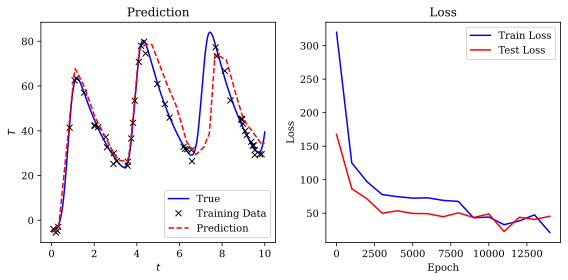

In [4]:
## Multi Layer Perceptron (MLP)
alpha = 1e-3  # Learning rate
epochs = 15000  # Number of training epochs

class MLP(eqx.Module):
    layers: list

    def __init__(self, key):
        keys = jax.random.split(key, 4)
        self.layers = [
            eqx.nn.Linear(1, 10 , key=keys[0]),  # Input layer
            eqx.nn.Linear(10, 10, key=keys[1]),  # Hidden layer 1
            eqx.nn.Linear(10, 10, key=keys[2]),  # Hidden layer 2
            eqx.nn.Linear(10, 10, key=keys[2]),  # Hidden layer 3
            eqx.nn.Linear(10, 1 , key=keys[3]),  # Output layer
        ]

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))  # Apply ReLU activation function
        return self.layers[-1](x)  # No activation on the output layer

@jit
@value_and_grad
def loss(model, x, y):
    """
    Compute the loss between the model predictions and the true values.
    
    Parameters:
    model : MLP model
    x : Input data
    y : True values
    
    Returns:
    loss : Computed loss
    """
    pred_y = vmap(model)(x)
    loss = la.norm(pred_y - y)
    return loss

@jit
def make_step(model, opt_state, x, y):
    """
    Perform a single optimization step.
    
    Parameters:
    model : MLP model
    opt_state : Optimizer state
    x : Input data
    y : True values
    
    Returns:
    model : Updated model
    opt_state : Updated optimizer state
    loss_value : Computed loss
    """
    loss_value, grads = loss(model, x, y)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value

# Initialize the model and optimizer
model = MLP(key)
optim = optax.sgd(alpha)
opt_state = optim.init(model)

# Lists to store training and test loss
ltrain_loss, ltest_loss, lepoch = [], [], []

# Training loop
for step in range(epochs):
    model, opt_state, train_loss = make_step(model, opt_state, X_data_train, Y_data_train)

    if step % 1000 == 0:
        lepoch.append(step)
        ltrain_loss.append(train_loss)
        ltest_loss.append(loss(model, X_data_test, Y_data_test)[0])
    if step % 5000 == 0:
        print(f"iteration : {step:5d} - Train MSE : {train_loss:.2f} - Test  MSE : {loss(model, X_data_test, Y_data_test)[0]:.2f}")

# Plotting the results
fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=300, tight_layout=True)

# First subplot for the prediction
axs[0].plot(t, y, 'b', label='True')
axs[0].plot(X_data_train, Y_data_train, 'xk', label='Training Data')
axs[0].plot(t, vmap(model)(t).squeeze(), '--r', label='Prediction')
axs[0].set_xlabel("$t$")
axs[0].set_ylabel("$T$")
axs[0].legend()
axs[0].set_title("Prediction")

# Second subplot for the loss
axs[1].plot(lepoch, ltrain_loss, 'b', label='Train Loss')
axs[1].plot(lepoch, ltest_loss, 'r', label='Test Loss')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].set_title("Loss")

plt.show()

### Noise, Bias, and Variance

The expected loss of a model, considering the uncertainties in both the training data $\mathcal{D}$ and the test data $y$, can be decomposed as:

$$
\mathbb{E}_{\mathcal{D}}\left[\mathbb{E}_y[L(x)]\right] = \underbrace{\mathbb{E}_{\mathcal{D}}\left[\left(f(x; \theta(\mathcal{D})) - f_\mu(x)\right)^2\right]}_{\text{Variance}} + \underbrace{\left(f_\mu(x) - \mu(x)\right)^2}_{\text{Bias}} + \underbrace{\sigma^2}_{\text{Noise}}
$$

In this equation:

- **Variance**: Represents the model's sensitivity to fluctuations in the training data. It quantifies how much the model's predictions at point $x$ would vary if we trained it on different datasets.
- **Bias**: Measures the error introduced by approximating a complex real-world problem with a simpler model. It is the squared difference between the expected prediction of the model and the true underlying function $\mu(x)$.
- **Noise**: Captures the irreducible error inherent in the data due to randomness or measurement errors. This component is unavoidable and sets a fundamental limit on the model's performance.

**Reducing Noise**:

The noise term $\sigma^2$ is intrinsic to the data and cannot be reduced through modeling. **It represents inherent uncertainty that we cannot eliminate**.

**Reducing Variance**:

Variance arises from the model's complexity and the finite size of the training data. **Increasing the amount of training data** can reduce variance by providing the model with more information, leading to more stable and generalized predictions.

**Reducing Bias**:

Bias results from simplifying assumptions made by the model. **We can reduce bias by increasing the model's capacity or complexity**, allowing it to capture more intricate patterns in the data.

**Bias-Variance Trade-off**:

There is an inherent trade-off between bias and variance:

- Increasing model complexity can **reduce bias** but may **increase variance**, especially with limited data.
- A highly complex model might **overfit** the training data, capturing noise as if it were a signal, leading to poor generalization on new data.
- Conversely, a very simple model might **underfit**, failing to capture essential patterns, resulting in high bias.

To achieve optimal performance, we seek a balance where both bias and variance are minimized as much as possible. This often involves selecting a model with the right capacity that is neither too simple nor too complex for the given dataset.

**Illustration of the Bias-Variance Trade-off**:

As the model capacity increases:

- **Bias decreases** because the model becomes more flexible and can better fit the training data.
- **Variance increases** because the model is more sensitive to the specific training data and may capture noise.

The total expected loss is minimized at an optimal model capacity where the sum of bias and variance is the lowest. Selecting this optimal point is crucial for building models that generalize well to unseen data.

### Double Descent

Double descent is a phenomenon observed in machine learning where the test error exhibits a distinctive pattern as model capacity increases. Initially, as the capacity grows, the test error decreases because the model can better capture the underlying patterns in the data. Traditionally, we expect that beyond a certain point, increasing capacity leads to overfitting, causing the test error to rise. However, with double descent, further increasing the model capacity after this peak causes the test error to decrease again.

**Understanding the Phenomenon:**

1. **Initial Descent (Underfitting Region):**
   - With low model capacity, the model cannot capture the complexity of the data.
   - Both training and test errors are high due to high bias.

2. **Peak (Overfitting Onset):**
   - As capacity increases, training error decreases.
   - Test error reaches a minimum but starts to increase as the model begins to overfit the training data.

3. **Second Descent (Interpolation Region):**
   - Further increasing capacity allows the model to fit the training data perfectly.
   - Surprisingly, the test error starts decreasing again despite the model overfitting the training data.
   - The model generalizes better due to inherent inductive biases and smoother interpolation between data points.

**Key Insights:**

- **Inductive Bias:** The model's tendencies influence how it generalizes beyond the training data. High-capacity models can interpolate training data smoothly, leading to better performance on unseen data.
- **Curse of Dimensionality:** In high-dimensional spaces, training data is sparse. Models rely on assumptions (like smoothness) to make predictions between known data points.
- **Model Capacity:** There's an optimal range where increasing capacity improves generalization, contradicting the traditional bias-variance trade-off.

**Implications for Machine Learning:**

- **Beyond Bias-Variance Trade-off:** Double descent challenges the conventional understanding that increasing model capacity beyond a certain point worsens test performance.
- **Designing Models:** Encourages the use of high-capacity models while being mindful of their inductive biases.
- **Data Considerations:** Highlights the importance of understanding data dimensionality and distribution when training complex models.

**Conclusion:**

Double descent reveals that increasing a model's capacity can eventually lead to improved generalization performance, even after overfitting occurs. This underscores the significance of model architecture and inductive biases in achieving optimal results in machine learning tasks.

# Regularization

We introduced regularization before. Using a regularizer can improve predictive accuracy by reducing the variance of the solution at the expense of a slight increase in bias, as described by the bias–variance trade-off. **In practice, the best generalization results are often achieved by combining a larger network with some form of regularization.** Regularization reduces the generalization gap between training and testing performance by adding explicit terms to the loss function that favor certain parameter choices.

## Inductive Bias (Prior)

In machine learning, when we aim to make predictions for new input values $\mathbf{x}$, we need to select a specific distribution from infinitely many possibilities. The preference for one distribution over others is known as an **inductive bias** or **prior**. This prior knowledge helps constrain the solution space based on background information. Often, we expect that small changes in input should lead to small changes in output, so we bias our solutions toward functions that vary smoothly. Regularization terms encourage model weights to have smaller magnitudes, introducing a bias toward functions that change more gradually with respect to the inputs. For example, in object detection within images, we can incorporate prior knowledge that an object's identity is generally independent of its position in the image—a concept known as **translation invariance**. Integrating such priors can greatly simplify building models that generalize well.

### No Free Lunch Theorem

Even highly flexible neural networks possess significant inductive biases. For instance, convolutional neural networks encode specific forms of inductive bias, such as translation equivariance, which are particularly beneficial in image-related applications. The **No Free Lunch Theorem**, derived from the saying "There's no such thing as a free lunch," states that every learning algorithm performs equally well when averaged over all possible problems. If a particular model or algorithm excels on some problems, it must perform worse on others.

Although the No Free Lunch Theorem is largely theoretical, it highlights the central importance of bias in determining a machine learning algorithm's performance. It's impossible to learn "purely from data" without any bias. In practice, bias may be implicit—for example, neural networks have a finite number of parameters, limiting the functions they can represent. Bias can also be explicitly encoded as prior knowledge related to the specific problem being solved. When developing general-purpose learning algorithms, we're seeking inductive biases appropriate for broad classes of applications we expect to encounter. However, for any given application, better results can be achieved by incorporating stronger, application-specific inductive biases.

The model-based machine learning perspective advocates making all assumptions explicit within models so that appropriate choices can be made for inductive biases. Inductive bias can be incorporated through the form of the distribution—for example, specifying that the output is a linear function of fixed basis functions. It can also be introduced by adding a regularization term to the error function during training. Another way to control a neural network's complexity is through the training process itself. Deep neural networks can generalize well even when the number of adjustable parameters exceeds the number of training data points, provided the training process is properly configured. Skillfully designing inductive biases and incorporating prior knowledge are essential in applying deep learning to real-world problems.

### Symmetry and Invariance

In many applications, predictions should remain unchanged, or **invariant**, under certain transformations of the input variables. For example, in image classification, an object should be assigned the same label regardless of its position within the image—this is called **translation invariance**. Similarly, changes in the size of the object should not affect its classification, known as **scale invariance**. Exploiting such symmetries to create inductive biases can significantly enhance machine learning models' performance and is a key aspect of geometric deep learning. Transformations like translation or scaling that preserve certain properties are known as symmetries.

To efficiently encourage a model to exhibit the required invariances, we can use several strategies:

1. **Pre-processing**: Incorporate invariance into a pre-processing stage by computing features of the data that are invariant under the desired transformations. Any subsequent regression or classification system using these features will inherently respect these invariances.

2. **Regularized Error Function**: Add a regularization term to the error function to penalize changes in the model's output when the input undergoes one of the invariant transformations.

3. **Data Augmentation**: Expand the training set by including transformed replicas of the training data points according to the desired invariances, assigning them the same target outputs as the original examples.

4. **Network Architecture**: Embed invariance properties directly into the neural network's structure through appropriate architectural choices.

### Equivariance

An important generalization of invariance is called **equivariance**, where the network's output transforms in a specific way when the input is transformed, rather than remaining constant. For example, consider a network that takes an image as input and outputs a segmentation map classifying each pixel as foreground or background. If the object in the image is translated, we expect the segmentation output to be translated in the same manner. In this case, the network's output changes predictably in response to transformations of the input.

## Explicit Regularization

In the "Maximum A Posteriori (MAP) Estimation" section of the ML 2 Notebook, we explored how to incorporate prior knowledge into our models. To steer the minimization process toward preferred solutions, we add an extra term to the loss function:

$$
\mathcal{L}(\boldsymbol{\theta}; \lambda) = \frac{1}{N} \sum_{n=1}^N \ell\left(\boldsymbol{y}_n, \boldsymbol{\theta}; \boldsymbol{x}_n\right) + \lambda C(\boldsymbol{\theta})
$$

Here, $C(\boldsymbol{\theta})$ is a scalar function that assigns higher values to less favored parameter configurations. The positive scalar $\lambda$ balances the influence of the original loss function and the regularization term. Incorporating this term alters the landscape of the loss function, often leading the training process to converge to different parameter values than it would without regularization.

To understand the effect of explicit regularization, imagine a loss function for a model that has multiple local minima and a global minimum. The regularization term adds a penalty that increases as parameters move away from a central, preferred region. This penalty smooths the overall loss function when combined with the original loss, reducing the number of local minima and shifting the global minimum. As a result, the optimization process is guided toward solutions that not only fit the data but also adhere to the preferred parameter characteristics.

### L2 Regularization (Weight Decay)

We've yet to discuss which solutions the regularization term should penalize—or, conversely, which solutions the prior should favor. Given the vast array of applications for neural networks, our regularization preferences need to be quite general. The most commonly used regularization term is based on the L2 norm, penalizing the sum of the squares of the parameter values:

$$
\mathcal{L}(\boldsymbol{\theta}; \lambda) = \frac{1}{N} \sum_{n=1}^N \ell\left(\boldsymbol{y}_n, \boldsymbol{\theta}; \boldsymbol{x}_n\right) + \lambda \sum_i \theta_i^2
$$

Here, $i$ indexes the parameters. **In neural networks, L2 regularization is typically applied to the weights but not the biases, a practice known as weight decay. This encourages the weights to be smaller, leading to a smoother output function.**

To illustrate the impact of weight decay, consider fitting a simplified neural network model using different values of the regularization coefficient $\lambda$. When $\lambda$ is small, the regularization has little effect, and the model may fit the training data closely—even to the point of overfitting. As $\lambda$ increases, the regularization term penalizes larger weights more strongly, resulting in a smoother function that fits the data less precisely but may generalize better to unseen data.

This improvement in test performance occurs for a couple of reasons:

- **Reduction of Overfitting**: If the network is overfitting, regularization forces it to balance fitting the training data with maintaining smoothness. This reduces variance (the model stops trying to pass through every data point exactly) but may introduce some bias (the model might underfit certain aspects of the data).
- **Handling Over-parameterization**: In networks with more parameters than necessary, extra capacity can lead to complex models that capture noise. Regularization promotes functions that smoothly interpolate between data points, making reasonable predictions in areas without training data.

Because weight decay is so prevalent in neural network training, modern deep learning frameworks have integrated it directly into optimization algorithms. This integration makes it convenient to apply weight decay alongside any loss function with minimal extra code. Additionally, incorporating weight decay at the optimization level offers computational benefits. Since the weight decay update depends only on the current parameter values, it can be seamlessly integrated into the parameter update steps without significant additional computational overhead.

iteration :     0 - Train MSE : 319.95 - Test  MSE : 167.68
iteration :  5000 - Train MSE : 140.56 - Test  MSE : 63.24
iteration : 10000 - Train MSE : 140.56 - Test  MSE : 63.24


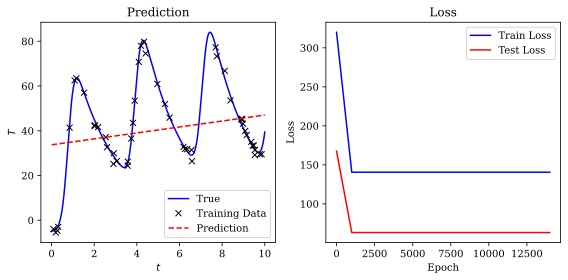

In [5]:
"""
Many research models make use of techniques such as learning rate scheduling, and gradient clipping. 
These may be achieved by chaining together gradient transformations such as optax.adam and optax.clip.
We will use Adam with weight decay (optax.adamw), a cosine learning rate schedule (with warmup) and also gradient clipping.
"""

# Data & Model from the previous example

# Initialize the model
model = MLP(key)

# Define the learning rate schedule with warmup and cosine decay
schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0, peak_value=1.0, warmup_steps=50, decay_steps=1_000, end_value=0.0
)

# Define the optimizer with gradient clipping and AdamW (Adam with weight decay)
optim = optax.chain(
    optax.clip(1.0),  # Gradient clipping
    optax.adamw(learning_rate=schedule)  # Adam with weight decay
)

# Initialize the optimizer state
opt_state = optim.init(model)

# Lists to store training and test loss
ltrain_loss, ltest_loss, lepoch = [], [], []

# Training loop
for step in range(epochs):
    model, opt_state, train_loss = make_step(model, opt_state, X_data_train, Y_data_train)

    if step % 1000 == 0:
        lepoch.append(step)
        ltrain_loss.append(train_loss)
        ltest_loss.append(loss(model, X_data_test, Y_data_test)[0])
    if step % 5000 == 0:
        print(f"iteration : {step:5d} - Train MSE : {train_loss:.2f} - Test  MSE : {loss(model, X_data_test, Y_data_test)[0]:.2f}")

# Plotting the results
fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=300, tight_layout=True)

# First subplot for the prediction
axs[0].plot(t, y, 'b', label='True')
axs[0].plot(X_data_train, Y_data_train, 'xk', label='Training Data')
axs[0].plot(t, vmap(model)(t).squeeze(), '--r', label='Prediction')
axs[0].set_xlabel("$t$")
axs[0].set_ylabel("$T$")
axs[0].legend()
axs[0].set_title("Prediction")

# Second subplot for the loss
axs[1].plot(lepoch, ltrain_loss, 'b', label='Train Loss')
axs[1].plot(lepoch, ltest_loss, 'r', label='Test Loss')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].set_title("Loss")

plt.show()

## Implicit Regularization

### Implicit Regularization in Gradient Descent

To explore the concept of implicit regularization, let's consider the continuous form of gradient descent where the step size is infinitesimally small. In this scenario, the change in the parameters $\theta$ is governed by the differential equation:

$$
\frac{\partial \theta}{\partial t} = -\frac{\partial \mathcal{L}}{\partial \theta}.
$$

Here, $\mathcal{L}$ represents the loss function. In practical applications, gradient descent implements discrete updates with a finite step size $\alpha$:

$$
\theta_{t+1} = \theta_t - \alpha \frac{\partial \mathcal{L}(\theta_t)}{\partial \theta}.
$$

The discretization introduces deviations from the continuous path due to the finite step size. This deviation can be interpreted by deriving a modified loss function $\tilde{\mathcal{L}}$ for the continuous case, such that it converges to the same point as the discrete updates on the original loss $\mathcal{L}$. It turns out that this modified loss function is:

$$
\tilde{\mathcal{L}}_{\text{GD}}(\theta) = \mathcal{L}(\theta) + \frac{\alpha}{4} \left\| \frac{\partial \mathcal{L}}{\partial \theta} \right\|^2.
$$

This additional term effectively penalizes the squared magnitude of the gradient, acting as an implicit regularizer.

To illustrate this, imagine a loss function where there is a family of global minima along a horizontal line at $\theta_1 = 0.61$. In the continuous gradient descent (with infinitesimal step size), starting from an initial point in the bottom-left, the path of $\theta$ (shown as a dashed blue line) smoothly reaches this line of minima. However, in discrete gradient descent with a finite step size (e.g., $\alpha = 0.1$), the trajectory (represented by arrows for the first few steps) deviates from the continuous path and converges to a different point. The finite step size causes the optimizer to settle at a location influenced by the implicit regularization term, which can be interpreted as the continuous gradient descent on the modified loss function $\tilde{\mathcal{L}}_{\text{GD}}(\theta)$. This demonstrates how discretization introduces an implicit bias toward certain solutions.

### Implicit Regularization in Stochastic Gradient Descent

A similar analysis applies to stochastic gradient descent (SGD). In SGD, we aim to find a modified loss function such that the continuous-time dynamics reach the same expected outcome as the average over possible stochastic updates. The modified loss function for SGD is given by:

$$
\begin{align*}
\tilde{\mathcal{L}}_{\text{SGD}}(\theta) &= \tilde{\mathcal{L}}_{\text{GD}}(\theta) + \frac{\alpha}{4B} \sum_{b=1}^{B} \left\| \frac{\partial \mathcal{L}_b}{\partial \theta} - \frac{\partial \mathcal{L}}{\partial \theta} \right\|^2 \\
&= \mathcal{L}(\theta) + \frac{\alpha}{4} \left\| \frac{\partial \mathcal{L}}{\partial \theta} \right\|^2 + \frac{\alpha}{4B} \sum_{b=1}^{B} \left\| \frac{\partial \mathcal{L}_b}{\partial \theta} - \frac{\partial \mathcal{L}}{\partial \theta} \right\|^2,
\end{align*}
$$

where $B$ is the batch size, and $\mathcal{L}_b$ represents the loss for batch $b$. This expression reveals that SGD introduces an additional regularization term related to the variance of the gradients across different batches.

Empirically, **SGD often generalizes better than standard gradient descent**, and smaller batch sizes tend to yield better performance than larger ones. One explanation is that the randomness inherent in SGD allows the algorithm to explore different parts of the loss surface, potentially escaping local minima. Alternatively, the implicit regularization term encourages solutions where the loss is consistently low across all data points, minimizing the gradient variance. Solutions with uniformly low loss are more likely to generalize well because they avoid overfitting to specific subsets of the data.

For example, when training a neural network on a dataset, using a larger learning rate can lead to better performance compared to smaller learning rates. Although each iteration takes a bigger step, the total number of iterations can be adjusted so that the optimizer has the opportunity to traverse the parameter space adequately. Similarly, training with smaller batch sizes introduces more noise into the gradient estimation, which can act as a regularizer and improve generalization. However, there is a trade-off, as too much noise can hinder convergence.

In practice, careful tuning of the learning rate and batch size is crucial. Larger learning rates can accelerate training and help the optimizer find flatter minima that generalize better, but if the learning rate is too high, the training may become unstable. Smaller batch sizes can improve generalization through implicit regularization, but very small batches may increase computational overhead and slow down training due to less efficient use of parallel hardware.

Understanding implicit regularization provides valuable insights into why certain optimization choices, like learning rate and batch size, can significantly impact the performance of neural networks. By recognizing how these factors influence the implicit bias of the training process, we can make informed decisions to enhance model generalization.

## Heuristics to Improve Performance

### Early Stopping

Early stopping is a technique where the training process is halted before the model fully converges. By stopping training at an earlier point, we aim to prevent the model from overfitting to the training data. The idea is that the model has already learned the essential patterns in the data but hasn't yet started to memorize the noise.

### Ensembling

Ensembling involves training multiple models and combining their predictions to improve generalization. By averaging the outputs of several models, an ensemble reduces variance and often achieves better performance than any single model. This approach helps to close the generalization gap between training and test data.

### Dropout

Dropout is a regularization method used during training, not during inference. At each iteration of stochastic gradient descent (SGD), a random subset of hidden units—typically 50%—is set to zero. This random "dropping out" of units prevents the network from becoming overly reliant on any single hidden unit and encourages the weights to distribute more evenly. As a result, the network becomes less sensitive to the omission of individual units, and the weights tend to have smaller magnitudes.

### Applying Noise

Building on the idea that dropout applies multiplicative Bernoulli noise to network activations, we can consider introducing noise to other parts of the network during training to enhance robustness.

**Adding Noise to Input Data:** Introducing random noise to the input data at each training step can smooth out the learned function. In regression problems, this is equivalent to adding a regularization term that penalizes large derivatives of the network's output with respect to its input, encouraging the model to be less sensitive to small input changes.

Consider what happens when we add noise with variance $\sigma_x^2$ to the input data at each SGD iteration. As the level of noise increases, the fitted model becomes smoother because it learns to generalize over the noisy inputs. This smoothing effect helps prevent the model from overfitting to the training data's noise.

**Adding Noise to the Weights:** Injecting noise directly into the weights during training encourages the network to make stable predictions even when the weights are slightly perturbed. This leads the training process to converge to local minima in wide, flat regions of the loss landscape, where small changes in weights have minimal impact on performance. Models that settle in these flat minima generally exhibit better generalization.

**Adding Noise to Labels:** In classification tasks, the maximum likelihood criterion pushes the network to predict the correct class with absolute certainty, often resulting in extremely high activations for the correct class and very low activations for incorrect classes before the softmax layer. By adding noise to the labels, we prevent the network from becoming overly confident, encouraging it to produce more calibrated probabilities and improving generalization.

### Augmentation

Data augmentation involves transforming input data examples in ways that do not alter their corresponding labels, effectively increasing the size and diversity of the training set. For instance, in an image classification task aiming to detect birds, we can rotate, flip, blur, or adjust the color balance of the images. These transformations produce new training examples where the label "bird" remains valid. Augmentation helps the model become invariant to such transformations, enhancing its ability to generalize to new, unseen data.

### Summary of Regularization Methods

The regularization techniques discussed aim to improve generalization by employing one or more of the following mechanisms:

- **Smoothing the Function:** Methods like adding noise to inputs or applying weight decay encourage the model to produce smoother output functions, reducing overfitting to the training data's noise.
  
- **Increasing Effective Data:** Data augmentation expands the training set with transformed versions of the data, providing more varied examples without the need to collect new data.

- **Combining Multiple Models:** Ensembling combines predictions from multiple models to mitigate uncertainties and reduce variance, often yielding better performance than individual models.

- **Finding Wide Minima:** Techniques such as adding noise to the weights or using dropout encourage the training process to converge to wider, flatter minima in the loss landscape. Models that settle in these regions are more robust, as small deviations in parameters have minimal effect on the loss.

By understanding and applying these heuristics, we can enhance the performance of neural networks, leading to models that generalize better to unseen data.

# A Recipe for Training Neural Networks

*The following content is inspired by Andrej Karpathy's blog post "[A Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/)".*

One of the significant challenges in training neural networks is preventing the inadvertent introduction of excessive complexity, which can lead to elusive bugs and misconfigurations that are hard to detect and resolve.

## Become Familiar with Your Data

Before engaging with neural network architectures or code, it's essential to deeply understand your dataset. Invest substantial time—several hours—examining thousands of examples to comprehend their distribution and uncover patterns or anomalies. Human intuition is powerful for spotting issues like duplicate entries, corrupted data, imbalances, or biases. Reflect on how you process and classify the data yourself to gain insights into the features and architectures that might be effective.

Consider the following aspects:

- **Feature Importance**: Do local features suffice, or is global context necessary?
- **Variation Analysis**: What types of variation exist? Can spurious variations be removed through preprocessing?
- **Spatial Relevance**: Does the spatial arrangement matter, or can it be abstracted away (e.g., via pooling)?
- **Detail Significance**: How much detail is crucial? To what extent can images be downsampled without losing important information?
- **Label Quality**: Assess the noise level in the labels and consider its impact on training.

Understanding your data thoroughly enables you to interpret the model's predictions and misclassifications more effectively. If the neural network produces unexpected results, a solid grasp of the data can help identify whether the issue lies in the data itself or the model.

Additionally, write scripts to filter, sort, and visualize your data based on various criteria—such as label types, annotation sizes, or other relevant features. Examining distributions and identifying outliers can reveal hidden problems in data quality or preprocessing that need to be addressed before training.

## Set Up the Training and Evaluation Framework with Simple Baselines

Rather than jumping into training complex models, start by establishing a reliable training and evaluation pipeline using a simple, well-understood model. This foundational step helps ensure that your entire workflow is correct and that you can trust the results of your experiments.

Follow these best practices:

- **Fixed Random Seed**: Use a consistent random seed to make your experiments reproducible. This eliminates variability due to random initialization or processing order.
  
- **Simplify the Setup**: Disable any non-essential components like data augmentation or complex regularization techniques. Introduce these features later once the basic pipeline is verified.
  
- **Comprehensive Evaluation**: When tracking metrics like test loss or accuracy, evaluate them over the entire test set rather than on individual batches. This provides a more reliable assessment of performance.
  
- **Verify Initial Loss**: Ensure that the initial loss value matches expected theoretical values. For example, with a properly initialized softmax classifier, the initial loss should be approximately \(-\log(1 / \text{number of classes})\).
  
- **Proper Weight Initialization**: Initialize model weights thoughtfully. If you're working with regression targets that have a mean of 50, set the final layer's bias to 50. For imbalanced classification tasks, adjust the initial biases to reflect the class distribution.
  
- **Establish Human-Level Baselines**: If possible, determine human performance on your task as a benchmark. Alternatively, use multiple annotations per example to assess the variability and establish an upper bound on performance.
  
- **Input-Independent Baseline**: Train a model that makes predictions without considering the input data (e.g., by using constant inputs). This helps confirm that your model is learning meaningful patterns from the actual data.
  
- **Overfit a Small Batch**: Attempt to overfit your model on a small batch of data (even just a few examples). Increase the model capacity if necessary and ensure it can achieve near-zero loss on this batch. Visualize the predictions to confirm they match the targets exactly.
  
- **Check Training Loss Decrease**: Starting with a simple model, verify that increasing the model's capacity leads to a decrease in training loss, as expected.
  
- **Visualize Model Inputs**: Inspect the processed inputs fed into the model to ensure they are correctly preprocessed and augmented. Visualizing these inputs can help catch data handling errors early.
  
- **Monitor Prediction Evolution**: Visualize model predictions on a fixed set of examples throughout training. Observing how predictions change over time can provide insights into the learning dynamics and help detect issues like instability or inappropriate learning rates.
  
- **Trace Dependencies with Gradients**: Utilize backpropagation to confirm that gradients flow correctly through the network. For example, verify that the gradient of a loss associated with a specific input only affects that input.
  
- **Implement Specific Cases Before Generalizing**: Start by coding specific functionalities tailored to your immediate needs. Once these are verified to work correctly, generalize the code as needed. This approach minimizes the risk of introducing bugs.

## Overfitting

With a solid understanding of your data and a reliable training pipeline, the next step is to develop a model that can capture the underlying patterns in the training data.

**Strategies:**

- **Select an Appropriate Model**: Begin with proven architectures suitable for your task. For image classification, this might be a standard convolutional network like ResNet-50. Avoid experimenting with novel architectures until you have established a strong baseline.
  
- **Use a Robust Optimizer**: Start with the Adam optimizer using a learning rate of \(3 \times 10^{-4}\). Adam is generally more forgiving with hyperparameters and can simplify the initial training phase. For certain models like convolutional networks, finely tuned stochastic gradient descent (SGD) may eventually offer better performance but requires careful tuning.
  
- **Incrementally Add Complexity**: If your model accepts multiple types of inputs or signals, incorporate them one at a time. Ensure that each addition leads to the expected improvement before adding more complexity.
  
- **Carefully Manage Learning Rate Schedules**: Be cautious with default learning rate decay schedules, especially if you're adapting code from other projects. Schedules based on epoch counts may not translate well to your dataset's size or complexity. Consider starting with a constant learning rate and tuning the schedule later.
  
By initially focusing on achieving low training loss, you can confirm that your model has the capacity to learn the data. If it cannot overfit the training data, there might be fundamental issues with the model architecture, data processing, or implementation that need to be resolved.

## Regularization

Once you have a model that fits the training data well, the goal is to improve its generalization performance on unseen data, even if it means sacrificing some training accuracy.

**Regularization Techniques:**

- **Increase Training Data**: The most effective way to enhance generalization is to gather more real-world training data. This method provides new information for the model to learn and reduces overfitting.
  
- **Data Augmentation**: Apply transformations to your existing data (e.g., rotations, flips, color jittering) to create new training examples. This helps the model become invariant to certain changes and improves robustness.
  
- **Creative Augmentation Strategies**: Employ advanced techniques like synthetic data generation, domain randomization, or using simulations to expand your dataset in meaningful ways.
  
- **Leverage Pretrained Models**: Utilize models pretrained on large datasets. Fine-tuning pretrained networks can lead to better performance, especially when training data is limited.
  
- **Reduce Input Complexity**: Simplify the inputs by removing features that may contribute noise or be irrelevant. This reduction can help the model focus on the most informative aspects of the data.
  
- **Decrease Model Complexity**: Simplify the model by reducing its size or depth. Smaller models have less capacity to overfit and may generalize better on limited data.
  
- **Adjust Batch Size**: Smaller batch sizes can introduce noise into the training process, which can act as a form of regularization. However, balance this with computational efficiency considerations.
  
- **Apply Dropout Sparingly**: Introduce dropout layers to prevent co-adaptation of neurons. For convolutional networks, spatial dropout (`Dropout2D`) can be used. Be cautious, as dropout can interact with batch normalization in complex ways.
  
- **Increase Weight Decay**: Strengthen L2 regularization by increasing the weight decay hyperparameter, which penalizes large weights and encourages simpler models.
  
- **Implement Early Stopping**: Monitor validation performance and halt training when the model starts to overfit. This prevents the model from learning noise in the training data.
  
- **Consider Larger Models with Early Stopping**: Sometimes, larger models trained with early stopping can outperform smaller ones, as they may capture more complex patterns before overfitting.

Additionally, inspect the learned features and internal representations:

- **Visualize First-Layer Weights**: In image models, the first-layer filters should display coherent patterns like edge detectors or color blobs. Random or noisy patterns might indicate problems.
  
- **Examine Activations**: Check activations throughout the network to identify any unusual behavior that could signal issues with training or model architecture.

## Hyperparameter Tuning

Fine-tuning hyperparameters is critical for optimizing model performance.

**Best Practices:**

- **Random Search Over Grid Search**: When tuning multiple hyperparameters, random search is generally more effective than grid search. It allows for a broader exploration of the hyperparameter space and can more efficiently identify optimal configurations.
  
- **Automated Hyperparameter Optimization**: Consider using Bayesian optimization tools or hyperparameter tuning libraries to systematically explore the hyperparameter space.

## Maximizing Performance

To achieve the best possible performance from your neural network:

- **Ensemble Models**: Combining predictions from multiple models can lead to significant performance improvements. If computational constraints prevent deploying ensembles, explore techniques like knowledge distillation to compress the ensemble into a single model.
  
- **Allow Extended Training**: Don't be too eager to stop training when progress seems to slow down. Neural networks can continue to improve with additional training time, sometimes leading to breakthroughs in performance.

By methodically applying these strategies—deep data understanding, careful setup, disciplined training, regularization, hyperparameter tuning, and perseverance—you can develop effective neural network models that perform well on real-world tasks.

# Facts about Deep Learning

- **The Lottery Ticket Hypothesis**: In 2019, Frankle and Carbin introduced the concept of the lottery ticket hypothesis. They demonstrated that for overparameterized neural networks, such as VGG, it's possible to identify smaller subnetworks that can achieve the same or even better performance than the full network. The procedure involves:

    1. **Training the full network** to completion.
    2. **Pruning** the weights with the smallest magnitudes, effectively removing less important connections.
    3. **Reinitializing** the remaining weights to their original values from before the initial training.
    4. **Retraining** this smaller, pruned network from scratch.

  Crucially, this approach only works when the pruned network is reinitialized to its original weights; reinitializing with new random weights does not yield the same results. The findings suggest that the original, larger network contains "winning tickets"—small, trainable subnetworks that are inherently capable of learning effectively. This implies that the sheer number of parameters isn't the sole factor in a network's success; instead, the presence of these effective subnetworks plays a key role. While it is suspected that the depth of the network might influence the number of such subnetworks for a given parameter count, a precise understanding of this relationship remains an open area of research.

- **The Alignment Problem and Reward Hacking**: Machine learning models often make predictions used to inform decisions that aim to minimize expected loss. However, crafting a loss function that perfectly encapsulates all human preferences and constraints is inherently challenging. This difficulty can lead to **reward hacking**, where an AI system aggressively optimizes the provided reward function but in doing so exploits gaps or oversights, leading to unintended and undesired behaviors. Reward hacking is a manifestation of the broader **alignment problem**, which highlights the mismatch between the objectives we set for our algorithms and the outcomes we truly desire. This issue raises significant concerns in AI ethics and safety.

  To address the alignment problem, Stuart Russell proposes avoiding the explicit specification of a reward function. Instead, he suggests that machines should infer the intended reward by observing human behavior—a process known as inverse reinforcement learning. Despite its potential, this approach has challenges. Relying solely on past human behavior may be undesirable, as it can perpetuate existing biases present in the training data.

  The conventional view of AI envisions autonomous systems making independent decisions, steering toward the development of **Artificial General Intelligence (AGI)**. As an alternative, the concept of **Augmented Intelligence** emphasizes the creation of intelligent tools that assist humans while keeping them involved in the decision-making process. Examples include adaptive cruise control in vehicles or autocomplete features in search engines. From this perspective, AI and machine learning components become integral parts of complex, semi-autonomous systems—much like autopilot in airplanes, online trading platforms, or advanced medical diagnostic equipment—where human oversight remains essential.